## Context
0. The purpose of data analysis
1. Data preview
2. EDA
3. Preprocessing
4. Modeling
5. Optimization and Evaluation
6. Conclusion

## 0. The purpose of data analysis
Take a look how the star dataset look like and build some star type classifier based on star dataset.

## 1. Data preview

In [ ]:
# Basic library for Python
import numpy as np
import pandas as pd
import os

In [ ]:
os.listdir("../input/star-dataset/")

In [ ]:
# Load star data
data = pd.read_csv("../input/star-dataset/6 class csv.csv")

In [ ]:
# see the first five rows of data
data.head()

In [ ]:
print("The shape of data is", data.shape)

## 2. EDA

In [ ]:
# Let's see what kind of data types are in data
data.info()

As you can see, we got 2 int variables, 3 float variables and 2 object variables.  
Star type is target(y) variable and other variables are independent(X) variable.  
Luckily we got clean data with non-null data.  
With this information we could consider **scaling and dummy variables** in preprocessing step.

In [ ]:
# Take a look whole data
data.describe(include="all")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
sns.pairplot(data = data, hue = "Star type")

In [ ]:
sns.distplot(data["Temperature (K)"])
plt.show()

Temperature (K) is right skewed

In [ ]:
print("Temperature (k) skewnewss:", data["Temperature (K)"].skew())
print("Temperature (k) kurtosis:", data["Temperature (K)"].kurt())

In [ ]:
sns.distplot(data["Luminosity(L/Lo)"])
plt.show()

Luminosity(L/Lo) is right skewed

In [ ]:
print("Luminosity(L/Lo) skewnewss:", data["Luminosity(L/Lo)"].skew())
print("Luminosity(L/Lo) kurtosis:", data["Luminosity(L/Lo)"].kurt())

In [ ]:
sns.distplot(data["Radius(R/Ro)"])
plt.show()

Radius(R/Ro) is right skewed

In [ ]:
print("Radius(R/Ro) skewnewss:", data["Radius(R/Ro)"].skew())
print("Radius(R/Ro) kurtosis:", data["Radius(R/Ro)"].kurt())

In [ ]:
sns.distplot(data["Absolute magnitude(Mv)"])
plt.show()

Absolute magnitude(Mv) has bimodal distribution... but doesn't matter because classifiers that we will build are robust to distribution.

In [ ]:
print("Absolute magnitude(Mv) skewnewss:", data["Absolute magnitude(Mv)"].skew())
print("Absolute magnitude(Mv) kurtosis:", data["Absolute magnitude(Mv)"].kurt())

In [ ]:
ax = sns.countplot(data["Star color"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

This is so confusing...

In [ ]:
data["Star color"].unique()

In [ ]:
print("Star color has {} unique values.".format(len(data["Star color"].unique())))

Lower case, upper case, white space, hyphen make difference between same words.

In [ ]:
data["Star type"].value_counts().plot(kind="bar")
plt.show()

What a lucky day! We got so balanced target variable.  
If we have imbalanced target variable, the accuracy paradox could destory your classifier.

In [ ]:
data["Star type"].value_counts()

After I started eda, I got curious about domain knowledges(maybe a little bit of astronomy?) and I found this figure(H-R diagram?).

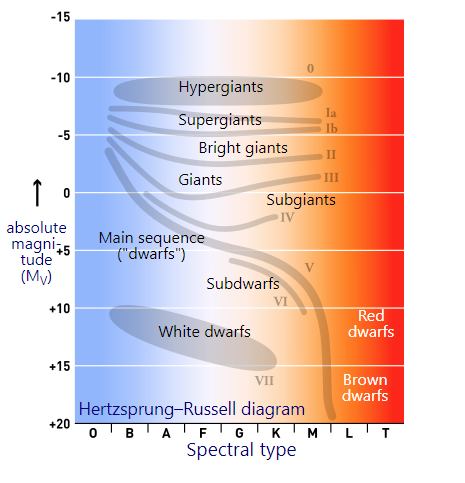  
figure from https://en.m.wikipedia.org/wiki/Stellar_classification

Let's find out this really works.

In [ ]:
ax = sns.scatterplot(data = data, x = "Spectral Class", y = "Absolute magnitude(Mv)", hue = "Star type")
ax.invert_yaxis()

It is hard to recognize the graph, because of Spectral Class order is a little bit messy in graph.  
I guess Spectral Class could be interpretable as binning of stars temperature.  
Cold to Hot  
O < B < A < F < G < K < M  
0   1   2   3   4   5   6

In [ ]:
mapping_Spec_class = {"O": 0, "B": 1, "A": 2, "F": 3, "G": 4, "K": 5, "M": 6}
data["labeled_spec"] = data["Spectral Class"].map(mapping_Spec_class)

In [ ]:
ax = sns.scatterplot(data = data, x = "labeled_spec", y = "Absolute magnitude(Mv)", hue = "Star type")
ax.invert_yaxis()

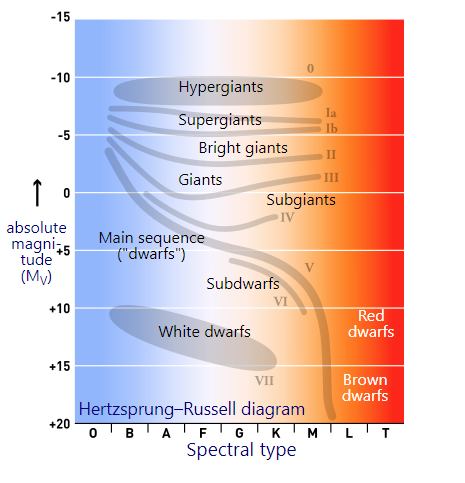 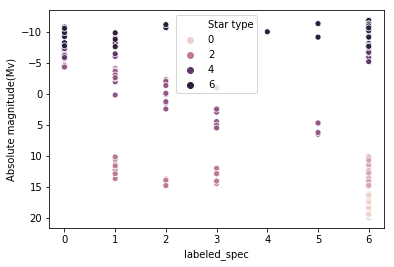

They look alike.  
Absolute magnitude and Spectral type will be a good guide for a star classifier.

In [ ]:
sns.catplot(y="labeled_spec", col="Star type", kind="count", orient = "h", height = 5, aspect = 1, data=data)
plt.show()

In [ ]:
data[["Star type","labeled_spec"]].pivot_table(columns=["Star type"],index=["labeled_spec"], aggfunc=len, fill_value = 0)

In [ ]:
sns.heatmap(data[["Star type","labeled_spec"]].pivot_table(columns=["Star type"],index=["labeled_spec"], aggfunc=len, fill_value = 0))
plt.show()

## 3. Preprocessing

Classifier will take numeric values so we need to transform all the variables into numeric.

In [ ]:
data.info()

What we need to do is chage Star color values in to **dummy format,** because they are just color which is norminal variable.

In [ ]:
#to lower case
data["Star color"] = data["Star color"].apply(lambda x: x.lower())

In [ ]:
len(data["Star color"].unique())

In [ ]:
#replace -  to " "
data["Star color"] = data["Star color"].apply(lambda x: x.replace("-"," "))
len(data["Star color"].unique())

In [ ]:
#remove white space
data["Star color"] = data["Star color"].apply(lambda x: x.replace(" ",""))
len(data["Star color"].unique())

In [ ]:
data["Star color"].unique()

Finally, we clean up the Star color!

In [ ]:
dummy_color = pd.get_dummies(data["Star color"]).astype("int64")
new_data = pd.concat([data, dummy_color], axis=1)

In [ ]:
new_data.head()

In [ ]:
new_data.info()

Now we can drop Star color and Spectral Class.  
Next step is scaling Temperature(K) to Absolute magnitude(Mv).

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

In [ ]:
X = new_data.drop(["Star type", "Star color", "Spectral Class"], axis=1)
y = new_data["Star type"]

In [ ]:
X.info()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 523)

In [ ]:
print("The shape of X_train:", X_train.shape)
print("The shape of X_test:", X_test.shape)

In [ ]:
print("The shape of y_train:", y_train.shape)
print("The shape of y_test:", y_test.shape)

Let's scaling Temperature(K) to Absolute magnitude(Mv).

In [ ]:
stsc = StandardScaler()
X_train_scaled = stsc.fit_transform(X_train.drop("labeled_spec", axis = 1))
X_test_scaled = stsc.transform(X_test.drop("labeled_spec", axis = 1))

In [ ]:
X_train.columns

In [ ]:
scaled_columns = list(X_train.columns)
scaled_columns.remove("labeled_spec")

In [ ]:
X_train.loc[X_train.index,scaled_columns] = X_train_scaled
X_test.loc[X_test.index,scaled_columns] = X_test_scaled

In [ ]:
X_train.head()

In [ ]:
X_test.head()

In [ ]:
stf = StratifiedKFold(n_splits=5, random_state=523)

## 4. Modeling
We will compare several models; KNN, RandomForest, XGB, LGBM

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_jobs=-1, n_neighbors=3)

In [ ]:
cv_scores = cross_val_score(cv=stf, estimator=knn, X = X_train, y = y_train, scoring = "accuracy")

In [ ]:
print("The Average accuracy for 5 folds KNN is {:.3f} +/- {:.3f}".format(cv_scores.mean(), cv_scores.std()))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=523)
cv_scores_rf = cross_val_score(cv=stf, estimator=rf_clf, X = X_train, y = y_train, scoring = "accuracy")

In [ ]:
print("The Average accuracy for 5 folds RF clf is {:.3f} +/- {:.3f}".format(cv_scores_rf.mean(), cv_scores_rf.std()))

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xg_clf = XGBClassifier(n_estimators=1000, n_jobs=-1, random_state=523)
cv_scores_xg = cross_val_score(cv=stf, estimator=xg_clf, X = X_train, y = y_train, scoring = "accuracy")

In [ ]:
print("The Average accuracy for 5 folds XGB clf is {:.3f} +/- {:.3f}".format(cv_scores_xg.mean(), cv_scores_xg.std()))

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators=1000, n_jobs=-1, random_state=523)
cv_scores_lgbm = cross_val_score(cv=stf, estimator=lgbm_clf, X = X_train, y = y_train, scoring = "accuracy")

In [ ]:
print("The Average accuracy for 5 folds LGBM clf is {:.3f} +/- {:.3f}".format(cv_scores_lgbm.mean(), cv_scores_lgbm.std()))

RF and XGB show good performance.  
Let's find out how they work with test set.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
%%time
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)

In [ ]:
cfmx_rf = confusion_matrix(y_test, rf_pred)

In [ ]:
sns.heatmap(cfmx_rf,annot=True,cbar=False)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(y_test, rf_pred))

In [ ]:
feat_importances = pd.Series(rf_clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(7).plot(kind='barh').invert_yaxis()

In [ ]:
%%time
xg_clf.fit(X_train, y_train)
xg_pred = xg_clf.predict(X_test)

In [ ]:
cfmx_xg = confusion_matrix(y_test, xg_pred)
sns.heatmap(cfmx_xg,annot=True,cbar=False)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(y_test, xg_pred))

In [ ]:
feat_importances = pd.Series(xg_clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(7).plot(kind='barh').invert_yaxis()

## 5. Optimization and Evaluation
It is interesting that train accuracy is over 99% and test f1 score is 1.00 for both models, so I think hyperparameter tuning is unnecessary.  
Evaluation process was already done, and it showed perfect f1 score.

## 6. Conclusion

I have opinions about data and classifier.

1. About data  
Well, I don't know whether this expression is appropriate for star dataset, but I feel like analyzing Star type version of iris data.  
I mean it is really fun experience to analyzing star dataset, because the dataset has so many hints,  
clean status(except star color column) and appropriate numbers of data for beginner like me.  
I want to say thank you to Data Author [@Deepraj Baidya](https://www.kaggle.com/deepu1109)! 


2. About classifier  
What data author wanted to do was using DNN for classification star type,  
but I made decision to use ML model after I saw shape of the dataset(240, 7).  
The dataset is not large enough and wide enough to use DNN compare to other datasets that capable of Deep learning models.  
If the dataset was images of star, DNN, especially CNN would be suitable for classification model.  
What I really surprised about model was that classifies star type like an H-R diagram.  
The model that was trained by star dataset finds out how to classify stars by itself in less than **ten seconds.**  
I know that dataset is small but it is still amazing.  


## **Thank you for reading! Have a nice day!**